In [8]:
import pandas as pd
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import product
from tqdm.notebook import tqdm
import statsmodels.api as sm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import datetime 

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
# import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session#, set_session, get_session

In [4]:
# # import torch
# print(torch.__version__)

# print(torch.version.cuda)
# # print(torch.backends.cudnn.version())
# print(torch.backends.cudnn.version())
# # print(torch.cuda.is_available())  #返回True则说明已经安装了cuda
# torch.cuda.device_count()


# import torch
# print(torch.cuda.is_available())  #返回True则说明已经安装了cuda
# torch.cuda.device_count()
tf.test.is_gpu_available()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-01-27 09:47:15.148332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


In [2]:
# 50_50小数据
all_stock_result = pd.read_pickle('all_stock_result.pkl')

x_train_split = [x[0] for x in list(all_stock_result.values())]
x_train_all = np.concatenate(x_train_split)

y_train_split = [y[2] for y in list(all_stock_result.values())]
y_train_all = np.concatenate(y_train_split)

x_test_split = [x[3] for x in list(all_stock_result.values())]
x_test_all = np.concatenate(x_test_split)

y_test_split = [y[5] for y in list(all_stock_result.values())]
y_test_all = np.concatenate(y_test_split)


In [2]:
# 90-30-1 数据
all_stock_result = pd.read_pickle('/code/task4-imbalance/train_result_k90_d30_n1/all_stock_result_k90_d30_n1.pkl')


x_train_split = [x[0] for x in all_stock_result]
x_train_all = np.concatenate(x_train_split)

y_train_split = [y[2] for y in all_stock_result]
y_train_all = np.concatenate(y_train_split)

x_test_split = [x[3] for x in all_stock_result]
x_test_all = np.concatenate(x_test_split)

y_test_split = [y[5] for y in all_stock_result]
y_test_all = np.concatenate(y_test_split)


In [2]:
# 150-120 大数据
all_stock_result = pd.read_pickle('/code/task4-imbalance/all_stock_result_k150_d120_n1.pkl')


x_train_split = [x[0] for x in all_stock_result]
x_train_all = np.concatenate(x_train_split)

y_train_split = [y[2] for y in all_stock_result]
y_train_all = np.concatenate(y_train_split)

x_test_split = [x[3] for x in all_stock_result]
x_test_all = np.concatenate(x_test_split)

y_test_split = [y[5] for y in all_stock_result]
y_test_all = np.concatenate(y_test_split)


-0.004186208312102462

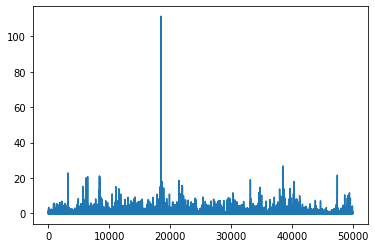

In [29]:
plt.plot(x_train_all[:50000,1,3])
x_train_all[:5000000,1,3].mean()

In [3]:
x_train_all.shape

(7493360, 30, 17)

In [4]:
y_test_all.shape

(7664686, 3)

In [ ]:
# model = keras.models.load_model('/code/task4-imbalance/models/model_l_bp_l_2d_allstock.h5')
# all_stock_result = pd.read_pickle('all_stock_result.pkl')
# model.predict(x_test_all[:,:,:-3])

In [12]:
import gc
gc.collect()

36009

In [5]:
with tf.device("/gpu:0"):   # gpu版本尝试
    # 对每个sample的最后一个ylabel进行预测
    model1 = Sequential()

    # model1.add(Dense(32))  # 维度为 32 的全连接层
    timesteps = x_train_all.shape[1]
    data_dim = x_train_all.shape[2]-3
    # data_dim = 5

    model1.add(LSTM(128, return_sequences=True,
                input_shape=(timesteps, data_dim)))  # 返回维度为 128 的向量序列

    model1.add(Dropout(0.5))    # dropout 0.5

    model1.add(LSTM(128, return_sequences=False))  # 返回维度为 128 的向量序列

    model1.add(Dense(32))  # 维度为 32 的全连接层
    model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果



    model1_opt = optimizers.Adam(lr = 0.0005)
    model1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

#     early_stop = EarlyStopping(min_delta=0.001, patience=3, monitor="val_accuracy")   

    # 对y序列进行预测
    his = model1.fit(
            x_train_all[:,:,:-3], 
        y_train_all, 
            batch_size=1024, 
            epochs=30,
            validation_data=(x_test_all[:,:,:-3], y_test_all),
        #     callbacks=[early_stop]
            )

    # model1.save('model_3l_3d_ndp.h5')       # 

Epoch 1/30
7313/7318 [============================>.] - ETA: 0s - loss: 0.8084 - accuracy: 0.6238

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [6]:
# # cpu_version

# # # 对每个sample的最后一个ylabel进行预测
# model1 = Sequential()

# # model1.add(Dense(32))  # 维度为 32 的全连接层
# timesteps = x_train_all.shape[1]
# data_dim = x_train_all.shape[2]-3
# # data_dim = 5

# model1.add(LSTM(128, return_sequences=True,
#                input_shape=(timesteps, data_dim)))  # 返回维度为 128 的向量序列

# model1.add(Dropout(0.5))    # dropout 0.5

# model1.add(LSTM(128, return_sequences=False))  # 返回维度为 128 的向量序列

# model1.add(Dense(32))  # 维度为 32 的全连接层
# model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果


# # model1.add(LSTM(512, return_sequences=True))  # 返回维度为 1024 的向量序列
# # model1.add(LSTM(512//2, return_sequences=True))  # 返回维度为 512 的向量序列
# # model1.add(LSTM(256//2, return_sequences=False))  # 返回维度为 256 的向量序列

# # model1.add(Dense(128))  # 维度为 128 的全连接层
# # model1.add(Dense(6))  # 维度为 6 的全连接层
# # model1.add(Dense(3, activation='softmax'))    # softmax 后的最终结果

# model1_opt = optimizers.Adam(lr = 0.0005)
# model1.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# early_stop = EarlyStopping(min_delta=0.002,patience=2)   

# # 对y序列进行预测 
# his = model1.fit(x_train_all[:,:,:-3], y_train_all,          
#           batch_size=1024, epochs=30,
#           validation_data=(x_test_all[:,:,:-3], y_test_all),
#           callbacks=[early_stop])

# # model1.save('model_3l_3d_ndp.h5')       # 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# fig output
plt.figure(figsize=(16,20))
ax1 = plt.subplot(2,1,1)
ax1.plot(his.history['loss'],label='train_loss')
ax1.plot(his.history['val_loss'], label='val_loss')
ax1.set_title('loss',fontdict={'size':16})

plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)

ax2 = plt.subplot(2,1,2)
ax2.plot(his.history['accuracy'],label='train_acc')
ax2.plot(his.history['val_accuracy'], label='val_acc')
plt.legend(prop = {'size':16})
plt.tick_params(labelsize=15)
plt.xticks(range(0,len(his.history['val_loss'])))
plt.xlabel('epoch',size=16)
ax2.set_title('accuracy',fontdict={'size':16})

# plt.set_ticks_position('top')
# plt.subplots_adjust(hspace=0.1)
plt.savefig('loss_allstock.png' , bbox_inches='tight')

df_result = pd.concat([pd.Series(x) for x in his.history.values()],axis=1)
df_result.columns = ['train_loss','train_acc','val_loss','val_acc']
df_result.index.names=['epoch']
df_result.iloc[-1:,:].round(4)

pd.DataFrame([[np.argmax(df_result.train_acc),df_result.train_loss.min(), df_result.train_acc.max(),np.argmax(df_result.val_acc),df_result.val_loss.min(), df_result.val_acc.max()]],columns=['best_train_epoch','train_loss','train_acc','best_val_epoch','val_loss','val_acc']).round(4)

# his.history